## 1-D Harmonic Oscillator PINN

**Machine learning and Deep learning has become increasingly popular across science, but do these algorithms actually “understand” the scientific problems they are trying to solve?**. 

This question has given rise to *Scientific Machine Learning (SciML)*, where **known physics of the process (scientific knowledge)** is integrated with machine learning workflows. This makes the Machine learning model to grasp the physics of the Engineering problems.

***Physics-Informed Neural Network(PINN)***, which is SciML, used to solve the scientific problems by using underlying classical physics equation of that problem and with limited data.

### 1. Problem Definition

In [1]:
"""Importing Packages."""
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchsummary import summary
from tqdm.notebook import tqdm
%matplotlib inline

In this, NN wants to predict the damped harmonic oscillation(classic problem in mechanics)[Ref](https://beltoforion.de/en/harmonic_oscillator/).
The underlying physics of Harmonic oscillation as follows,

![Oscillation](https://benmoseley.blog/wp-content/uploads/2021/08/oscillator.gif)


1D Harmonic oscillation depends on the balance of three forces: ***Inertia, Restoring force of the spring*** and ***Friction***.
$$ \normalsize \text{Inertia = } m \cdot \frac{d^{2}x}{dt^{2}} $$
$$ \normalsize \text{Restoring force of String = } - \mu \cdot \frac{dx}{dt} $$
$$ \normalsize \text{Friction = } - k \cdot x $$

Thus, 1D Harmonic oscillation is a linear, homogeneous, second-order differential equation with constant coefficients.

$$ m \cdot \frac{d^{2}x}{dt^{2}} + \mu \cdot \frac{dx}{dt} + k \cdot x = 0 $$
where, $$ \small m = \text{Mass of the Oscillator}, \mu = \text{Friction Coefficient}, k = \text{Spring Constant} $$

Initial Condition (Boundary Condition), $$ \small x(0) = 1, \space \frac{dx(0)}{dt} = 0 $$
 
In this example, we consider Underdamped case. $$ \small \delta < w_{0}, \space\space\space\space \text{where} \space\space \delta = \frac{\mu}{2m}, \space\space w_{0} = \sqrt{\frac{k}{m}}$$

The solution for Underdamped case, $$ \normalsize u(t) = x(t) = e^{-\delta t}(2A\cos(\phi + wt)) \space\space\space \small \text{,with} \space w = \sqrt{w_{0}^{2} - \delta^{2}} $$
Considering, $$ \small x(0) = 1, \space\space \text{we get} \space\space A = \frac{1}{2 \cos(\phi)} \space\space \text{with} \space\space \phi = \tan^{-1}(\frac{\delta}{w}) $$ 

In [2]:
def save_gif_PIL(outfile, files, fps = 5, loop = 0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp = outfile, format = 'GIF', append_images = imgs[1:], save_all = True, duration = int(1000/fps), loop = loop)

"""Defining actual oscillator function."""
def oscillator(d: int, w0: int, t: torch.Tensor) -> torch.Tensor:
    assert d < w0, "delta must be less than W0, since it is Underdamped case."
    w = np.sqrt((w0 ** 2) - (d ** 2))
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(phi + (w * t))
    exp = torch.exp(-d * t)
    u_t = exp * 2 * A * cos
    return u_t

### 2. Fully Connected Neural Network

In [3]:
class FCN(nn.Module):
    """
    Activation TanH is used because smoothness and overall S-shape of this function are similar to that of the sigmoid function. However, unlike the
    sigmoid function, the range of the outputs is centered at 0 and falls between (-1, 1). This makes the tanh activation
    function more appropriate for deep neural networks as it avoids creating a bias towards positive outputs. ReLU is
    more commonly used as an activation function in neural networks. However, it's unsuitable for PINNs due to its second
    derivative being zero[3].

    """
    def __init__(self, n_in: int, n_out: int, hidden_dim: int, n_layers: int):
        super().__init__()

        self.n_layers = n_layers
        self.in_layer = nn.Sequential(nn.Linear(n_in, hidden_dim),
                                      nn.Tanh()
                                     )   
        self.hidden_layers = nn.ModuleList()
        for _ in range(self.n_layers - 1):
            self.hidden_layers.append(nn.Sequential(*[nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]))
        self.out_layer = nn.Linear(hidden_dim, n_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.in_layer(x)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.out_layer(out)

        return out
        

In [4]:
ffn = FCN(1, 1, 34, 3)
ffn

FCN(
  (in_layer): Sequential(
    (0): Linear(in_features=1, out_features=34, bias=True)
    (1): Tanh()
  )
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=34, out_features=34, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=34, out_features=34, bias=True)
      (1): Tanh()
    )
  )
  (out_layer): Linear(in_features=34, out_features=1, bias=True)
)

In [5]:
x = torch.randn(1, 1)
summary(ffn, [x], device = 'cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 34]                  --
|    └─Linear: 2-1                       [-1, 34]                  68
|    └─Tanh: 2-2                         [-1, 34]                  --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-3                   [-1, 34]                  --
|    |    └─Linear: 3-1                  [-1, 34]                  1,190
|    |    └─Tanh: 3-2                    [-1, 34]                  --
|    └─Sequential: 2-4                   [-1, 34]                  --
|    |    └─Linear: 3-3                  [-1, 34]                  1,190
|    |    └─Tanh: 3-4                    [-1, 34]                  --
├─Linear: 1-2                            [-1, 1]                   35
Total params: 2,483
Trainable params: 2,483
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 34]                  --
|    └─Linear: 2-1                       [-1, 34]                  68
|    └─Tanh: 2-2                         [-1, 34]                  --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-3                   [-1, 34]                  --
|    |    └─Linear: 3-1                  [-1, 34]                  1,190
|    |    └─Tanh: 3-2                    [-1, 34]                  --
|    └─Sequential: 2-4                   [-1, 34]                  --
|    |    └─Linear: 3-3                  [-1, 34]                  1,190
|    |    └─Tanh: 3-4                    [-1, 34]                  --
├─Linear: 1-2                            [-1, 1]                   35
Total params: 2,483
Trainable params: 2,483
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 

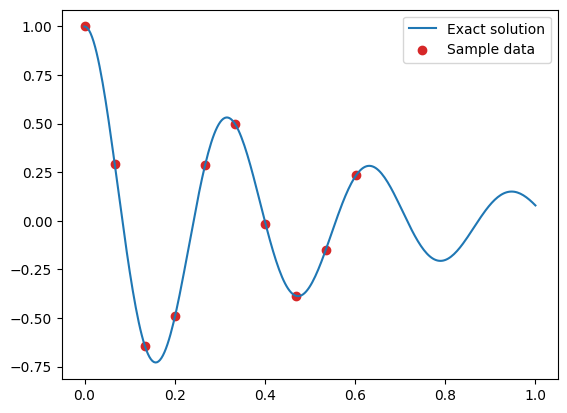

In [6]:
"""True solution by using actual oscillator equation with time space 0 to 1."""
d, w0 = 2, 20
t = torch.linspace(0, 1, 300).view(-1, 1)
y = oscillator(d, w0, t).view(-1, 1)

t_s = t[0:200:20]
y_s = y[0:200:20]

plt.figure()
plt.plot(t, y, label = "Exact solution")
plt.scatter(t_s, y_s, color = "tab:red", label = "Sample data")
plt.legend()
plt.show()

In [7]:
def plot_result(x: torch.Tensor, y: torch.Tensor, x_data: torch.Tensor, y_data: torch.Tensor, yh: torch.Tensor, i: int, xp: torch.Tensor = None, xb: torch.Tensor = None):
    "Pretty plot training results"
    plt.figure(figsize = (8,4))
    plt.plot(x[:, 0], y[:, 0], color = "grey", linewidth = 2, alpha = 0.8, label = "Exact solution")
    plt.plot(x[:, 0], yh[:, 0], color = "tab:blue", linewidth = 3, alpha = 0.8, label = "Neural network prediction")
    plt.scatter(x_data[:, 0], y_data[:, 0], s = 60, color = "tab:red", alpha = 0.4, label = 'Training data')
    if xp is not None:
        plt.scatter(xp[:, 0], torch.zeros_like(xp)[:, 0], s = 60, color = "tab:green", alpha = 0.4, 
                    label = 'Physics Training Points')
    if xb is not None:
        plt.scatter(xb[:, 0], torch.zeros_like(xb)[:, 0], s = 60, color = "tab:orange", alpha = 0.4, 
                    label = 'Boundary point')
    l = plt.legend(loc = (1.01, 0.34), frameon = False, fontsize = "large")
    plt.setp(l.get_texts(), color = "k")
    plt.text(1.065, 0.7, "Training step: %i"%(i+1), fontsize = "xx-large", color = "k")
    plt.axis("off")

In [9]:
os.makedirs('./Plots_default')

### 3. Conventional approach of NN

Using naive conventional data-driven approach to make the NN fit and predict the oscillation using Mean-Squared Error(as a Loss).

  0%|          | 0/5000 [00:00<?, ?it/s]

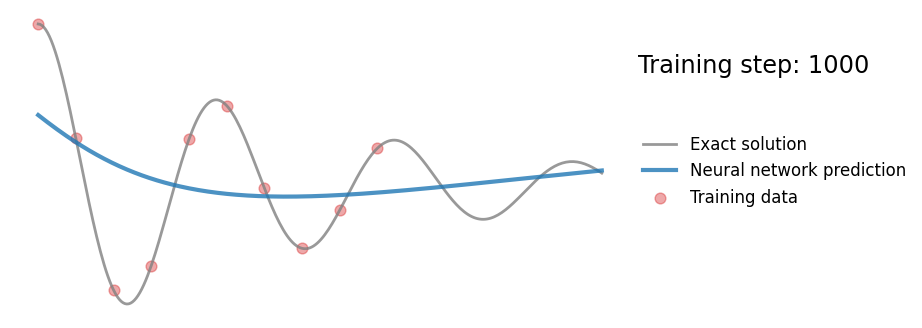

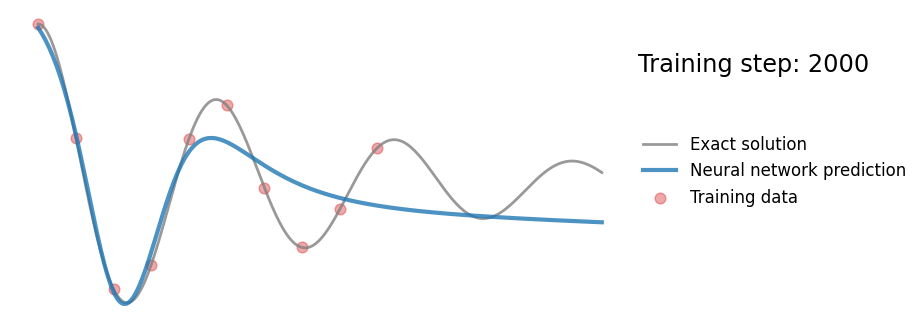

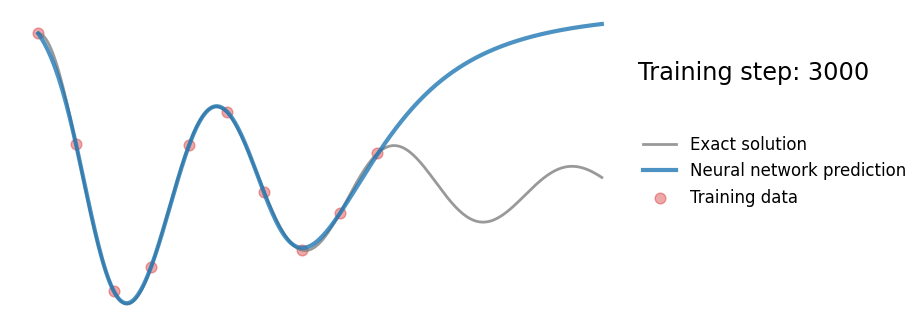

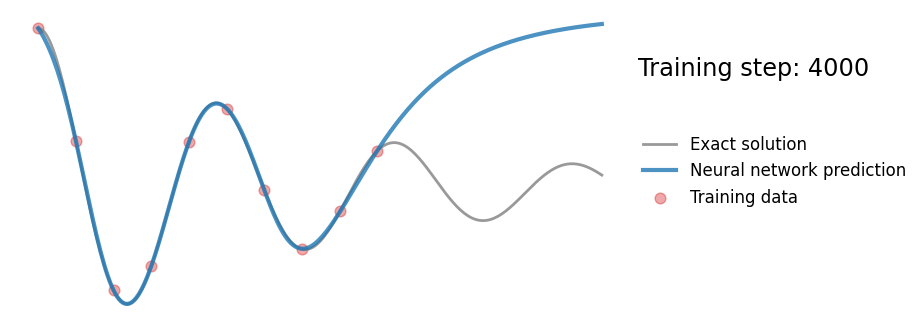

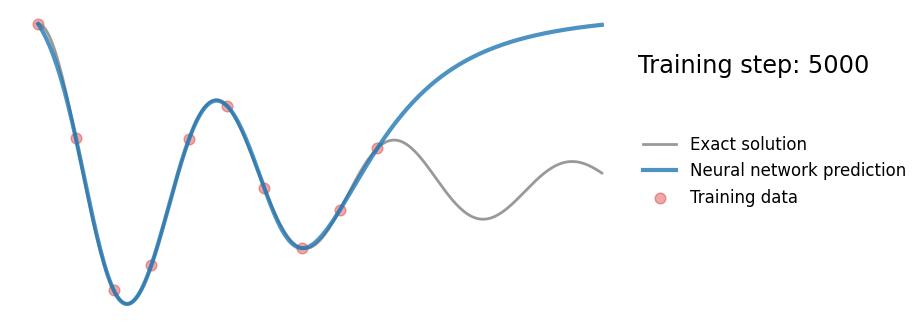

In [10]:
"""Training with MSE as Loss"""
torch.manual_seed(34)
fcn = FCN(1, 1, 34, 3)
optimizer = torch.optim.Adam(fcn.parameters(), lr = 1e-4)
Loss = []
files = []
for step in tqdm(range(5000)):
    fcn.train()
    y_pred = fcn(t_s)
    # MSE Loss
    loss = torch.mean((y_pred - y_s) ** 2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    Loss.append(loss.item())
    
    if (step + 1) % 10 == 0:
        fcn.eval()
        y_pred = fcn(t).detach()

        plot_result(t.detach(), y.detach(), t_s.detach(), y_s.detach(), y_pred, step)

        file = "Plots_default/nn_%.8i.png"%(step + 1)
        plt.savefig(file, bbox_inches = 'tight', pad_inches = 0.1, dpi = 100, facecolor = "white")
        files.append(file)

        if (step + 1) % 1000 == 0:
            plt.show()
        else:
            plt.close('all')


In [11]:
save_gif_PIL('Default.gif', files = files, fps = 40)

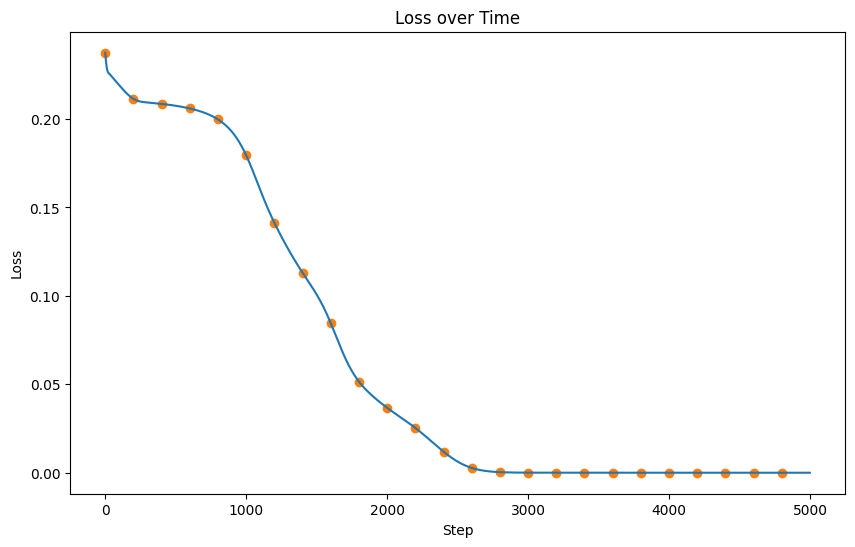

In [12]:
x = range(len(Loss))

plt.figure(figsize = (10, 6))
plt.plot(x, Loss ,'-')
plt.scatter(x[0:5000:200], Loss[0:5000:200], color = "tab:orange")
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()

It is seen that NN is able to fit the solution very closely to vicinity of training points, but it is not able to converge accurately outside those points.

### 4. PINN

In [13]:
os.makedirs('./Plots_pinn')

Now, NN is trained to minimize the Loss function that includes actual differential equation("*physical loss*").

Boundary Loss:

Tries to ensure that the solution learned by NN matches the initial condition $ \small \text{u(t=0) = 1} \space \text{and} \space u^{'}(t = 0) = 0.$

$$ \small \space\space \text{When t = 0} $$
$$ \normalsize (u_{NN}(t = 0; \theta) - 1)^{2} + (\frac{d}{dt}u_{NN}(t = 0; \theta) - 0)^{2} $$

Physical Loss:

Tries to ensure that the NN solution obeys the underlying differential equation at a set of training points $ \small \{t_{i}\} $ sampled over the space $\small [0, 1]$.

$$ \normalsize \frac{1}{M} \sum_{j}^{M} ([\frac{d^{2}}{dt^{2}} + \mu \frac{d}{dt} + k] \space u_{NN}(x_{j}; \theta))^{2} $$

Total Loss:

Combining the above loss with hyperparameters.

$$ \mathcal{L(\theta)} = \min [(u_{NN}(t = 0; \theta) - 1)^{2} + \space \lambda_{1}(\frac{d}{dt}u_{NN}(t = 0; \theta) - 0)^{2} + \space \lambda_{2}\frac{1}{M} \sum_{j}^{M} ([\frac{d^{2}}{dt^{2}} + \mu \frac{d}{dt} + k] \space u_{NN}(x_{j}; \theta))^{2}]$$
$$ \small \text{where}, \space \lambda_{1} \space \text{and} \space \lambda_{2} \space \text{are penalizing constants(hyperparameters) to ensure the stability of training.} $$

The gradients of the Loss Function with respect to it's input points of PINN is calculated using Autodifferentiation ($\small \text{torch.autograd}$).


  0%|          | 0/15000 [00:00<?, ?it/s]

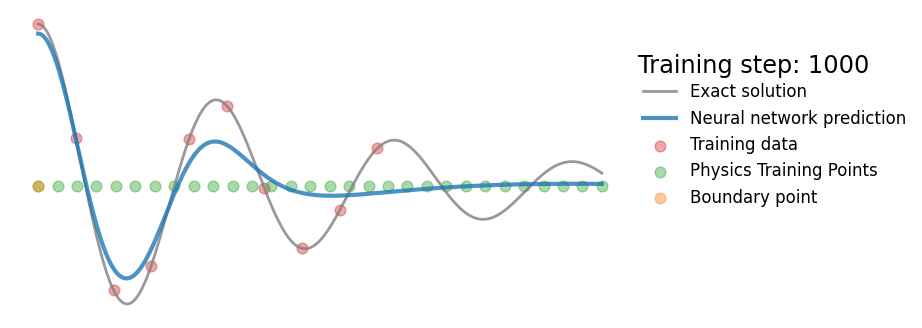

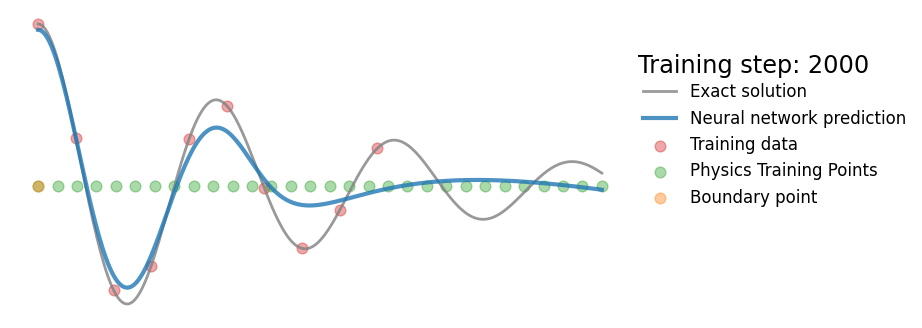

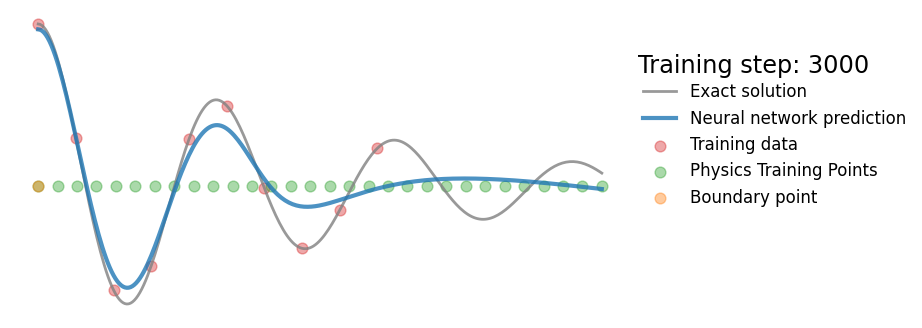

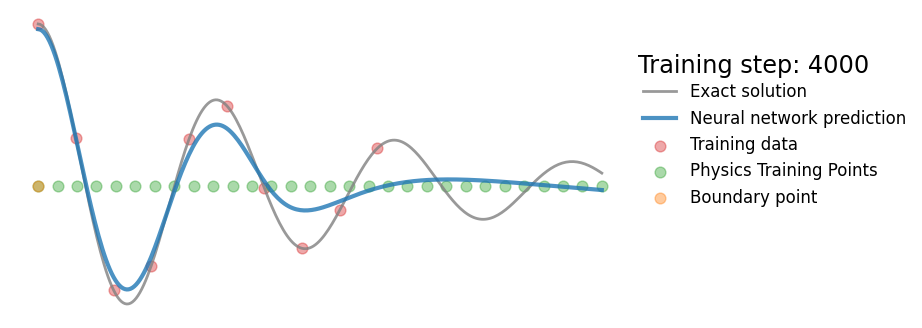

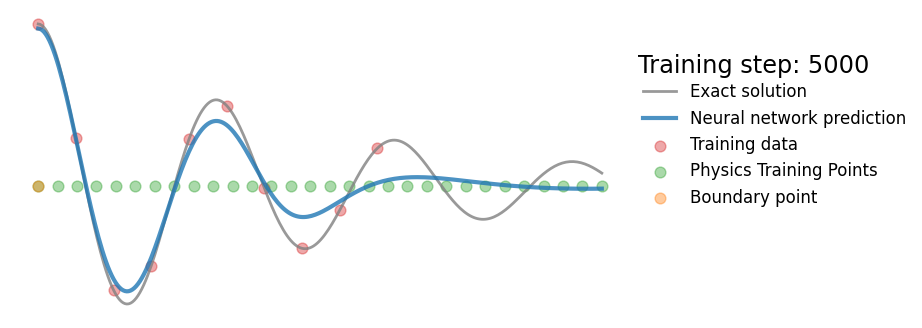

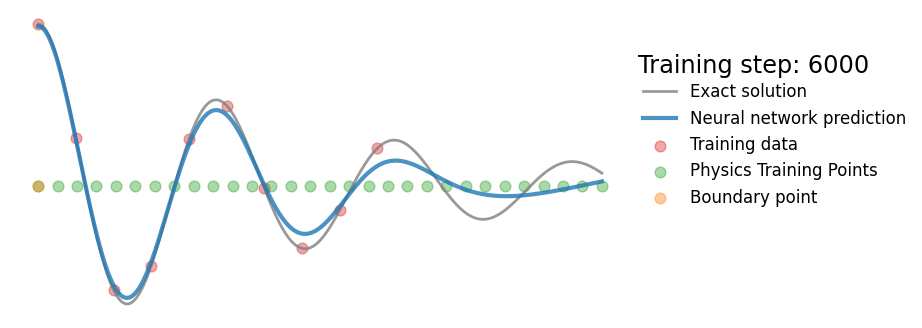

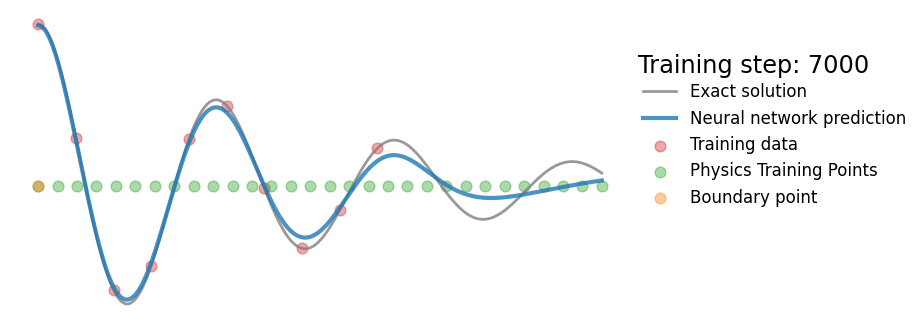

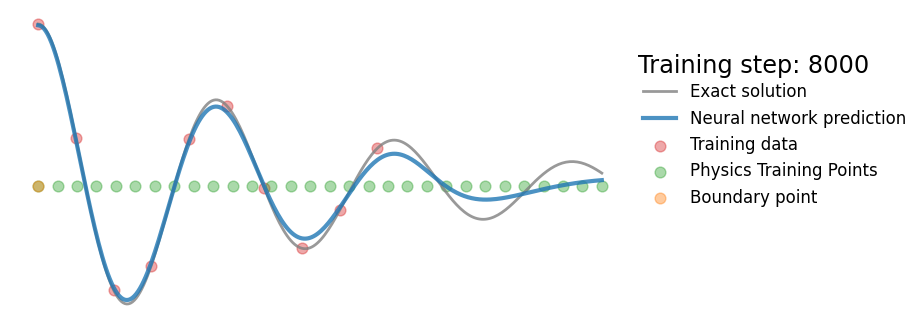

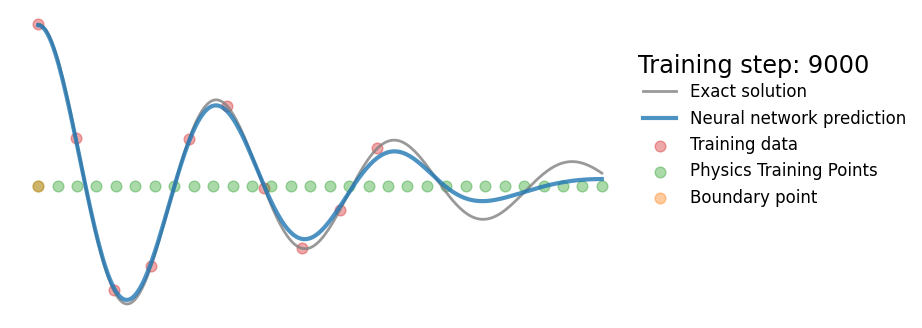

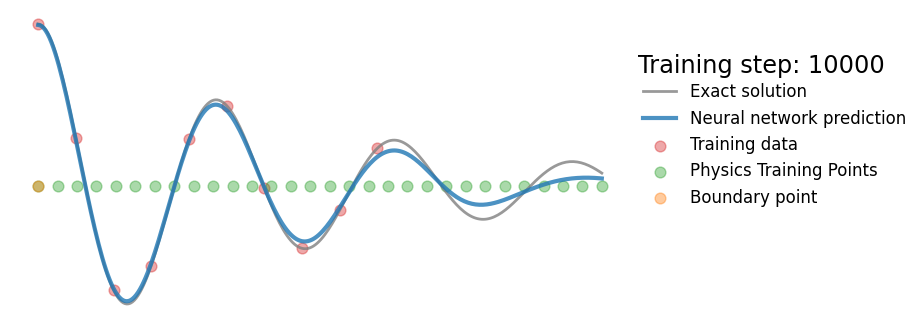

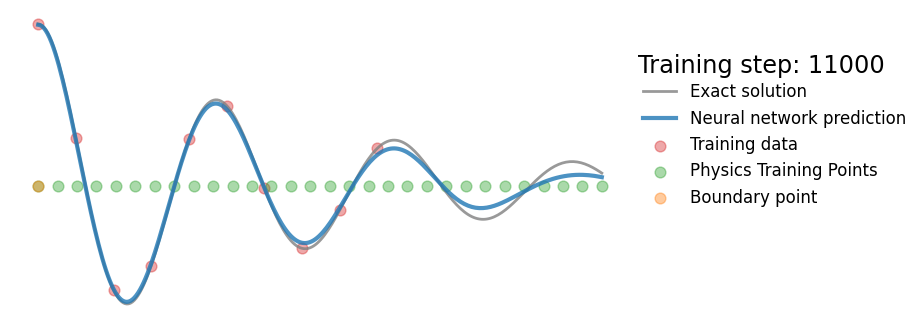

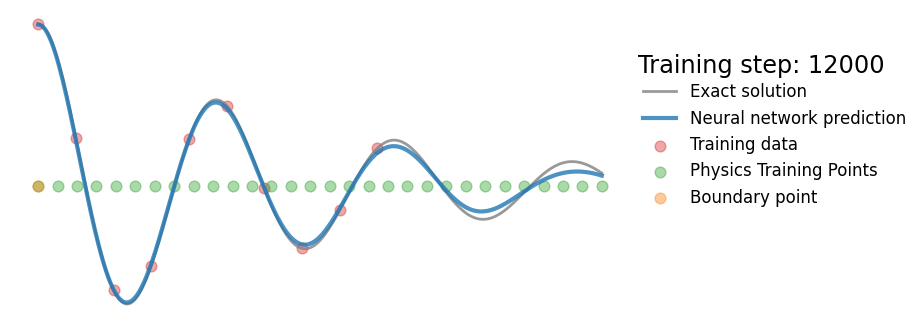

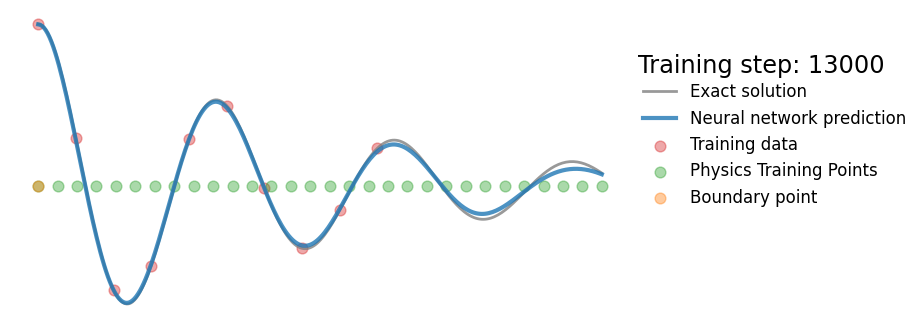

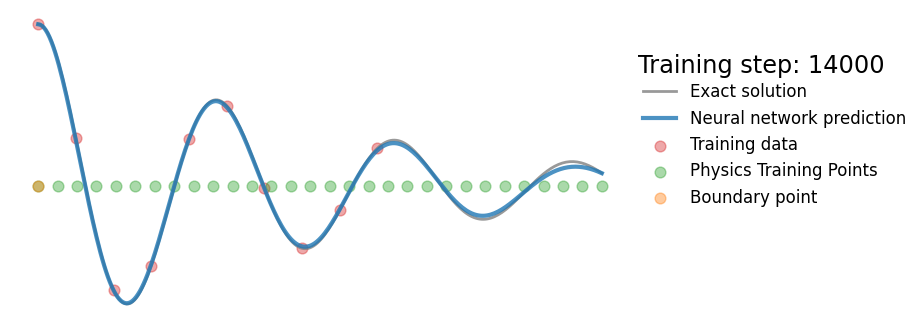

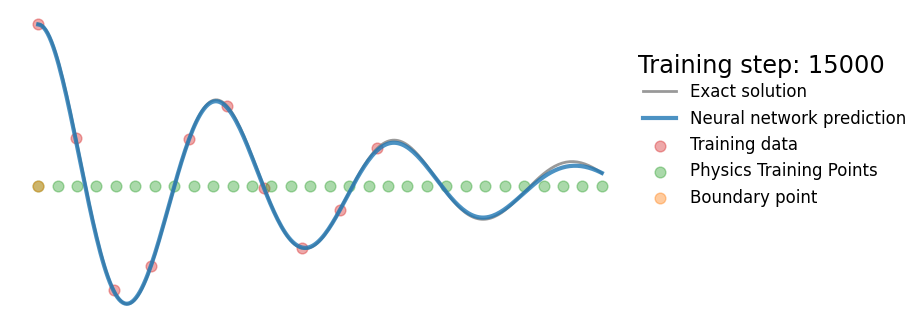

In [14]:
"""Training with boundary and physical loss. This makes as PINN"""
torch.manual_seed(34)

# Boundary point
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
# Physics points
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

mu, k = 2 * d, w0 ** 2
lambda1, lambda2 = 1e-1, 1e-4
fcn = FCN(1, 1, 34, 3)
optimizer = torch.optim.Adam(fcn.parameters(), lr = 1e-3)       
Loss = []
files = []
for step in tqdm(range(15000)):
    optimizer.zero_grad()
    # Boundary loss
    y_p_b = fcn(t_boundary)
    loss_b1 = (torch.squeeze(y_p_b) - 1) ** 2

    dudt_pinn = torch.autograd.grad(y_p_b, t_boundary, torch.ones_like(y_p_b), create_graph = True)[0]
    loss_b2 = (torch.squeeze(dudt_pinn) - 0) ** 2

    # Physical loss
    y_p_h = fcn(t_physics)
    dudt = torch.autograd.grad(y_p_h, t_physics, torch.ones_like(y_p_h), create_graph = True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph = True)[0]
    loss_p = torch.mean((d2udt2 + mu * dudt + k * y_p_h) ** 2)

    # Total loss
    loss = loss_b1 + lambda1 * loss_b2 + lambda2 * loss_p
    loss.backward()
    optimizer.step()
    Loss.append(loss.item())
    
    if (step + 1) % 10 == 0:
        y_pred = fcn(t).detach()

        plot_result(t.detach(), y.detach(), t_s.detach(), y_s.detach(), y_pred, step, xp = t_physics.detach(), xb = t_boundary.detach())

        file = "Plots_pinn/nn_%.8i.png"%(step + 1)
        plt.savefig(file, bbox_inches = 'tight', pad_inches = 0.1, dpi = 100, facecolor = "white")
        files.append(file)

        if (step + 1) % 1000 == 0:
            plt.show()
        else:
            plt.close('all')


In [21]:
save_gif_PIL('Pinn.gif', files = files, fps = 30)

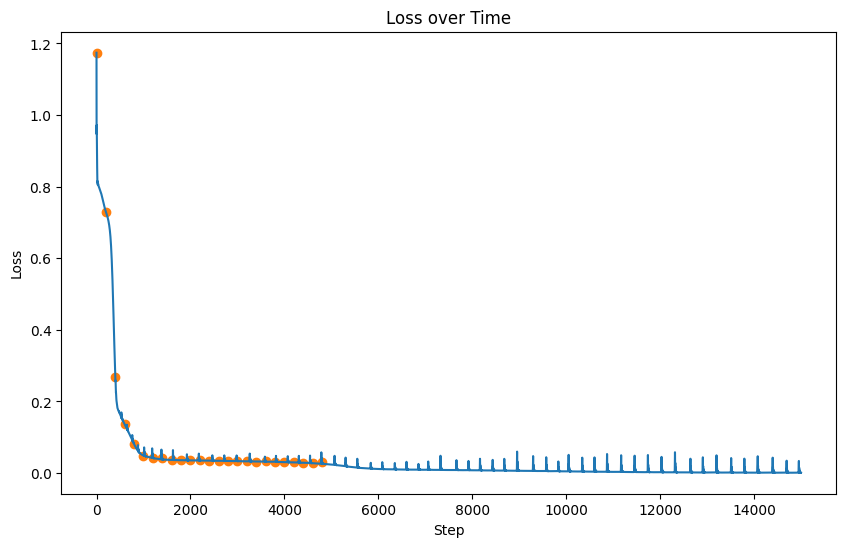

In [22]:
x = range(len(Loss))

plt.figure(figsize = (10, 6))
plt.plot(x, Loss ,'-')
plt.scatter(x[0:5000:200], Loss[0:5000:200], color = "tab:orange")
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()

It is seen that the additional ***"boundary loss"*** and ***"physics loss"*** in the loss function tries to ensure that the solution learned by the network is consistent with the known physics. Thus, NN converges for entire oscillation.

### 5. Learning Constant from noisy observation data

Given the noisy observation data, NN tries to estimate the unknown constant(In this case, $\mu$) of differential equation.

True value of mu: 4


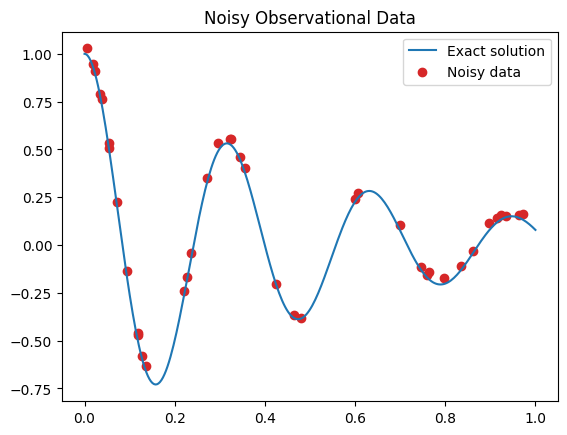

In [23]:
"""Solution for noisy observation data."""
t_obs = torch.rand(40).view(-1, 1)
y_obs = oscillator(d, w0, t_obs) + 0.04 * torch.rand_like(t_obs)

print(f"True value of mu: {d * 2}")
plt.figure()
plt.title("Noisy Observational Data")
plt.plot(t, y, label = "Exact solution")
plt.scatter(t_obs, y_obs, color = "tab:red", label = "Noisy data")
plt.legend()
plt.show()

In [24]:
os.makedirs('./Plots_noisy')

Data Loss:

It tries to make sure that the solution learned by NN fits the noisy observation dat that are given.

$$ \normalsize \frac{1}{N} \sum_{i}^{N} (u_{NN}(x_{i};\theta) - u_{obs}(x_{i}))^{2} $$

Physical Loss:
$$ \normalsize \frac{1}{M} \sum_{j}^{M} ([\frac{d^{2}}{dt^{2}} + \mu \frac{d}{dt} + k] \space u_{NN}(x_{j}; \theta))^{2} $$

Total Loss:
$$ \mathcal{L(\theta, \mu)} = \min [\frac{1}{N} \sum_{i}^{N} (u_{NN}(x_{i};\theta) - u_{obs}(x_{i}))^{2} + \space \lambda \frac{1}{M} \sum_{j}^{M} ([\frac{d^{2}}{dt^{2}} + \mu \frac{d}{dt} + k] \space u_{NN}(x_{j}; \theta))^{2}]$$

In this, the parameters $ \small \boldsymbol{\theta} $ and $ \small \boldsymbol{\mu}\text{(Friction coefficient)} $ are learned simultaneously.

  0%|          | 0/10000 [00:00<?, ?it/s]

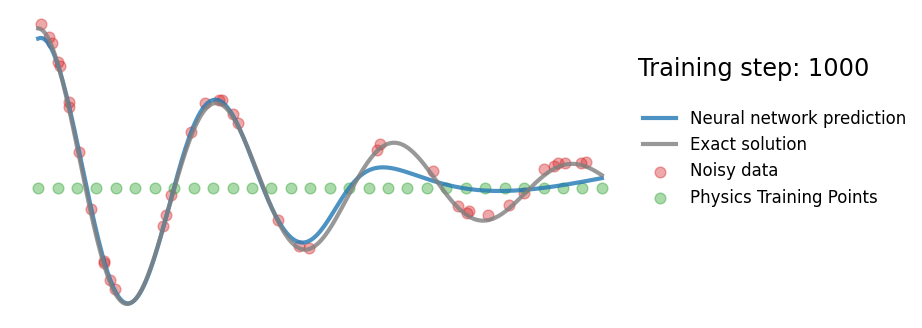

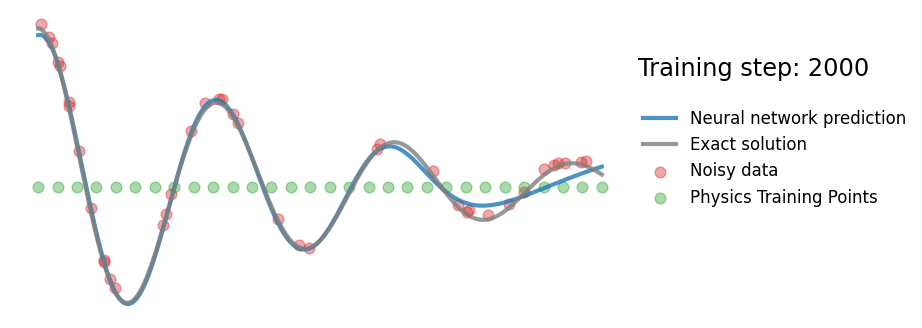

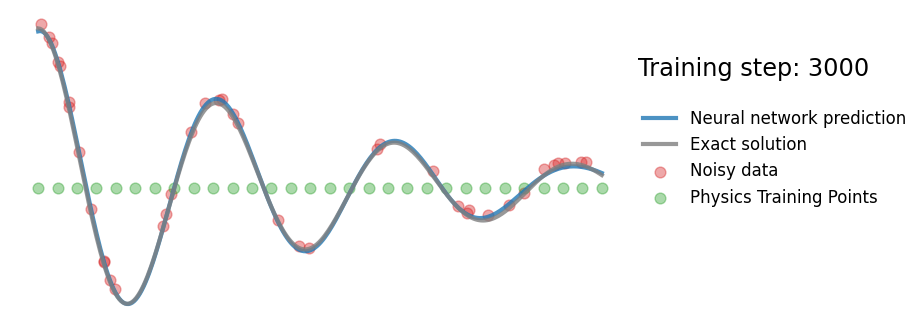

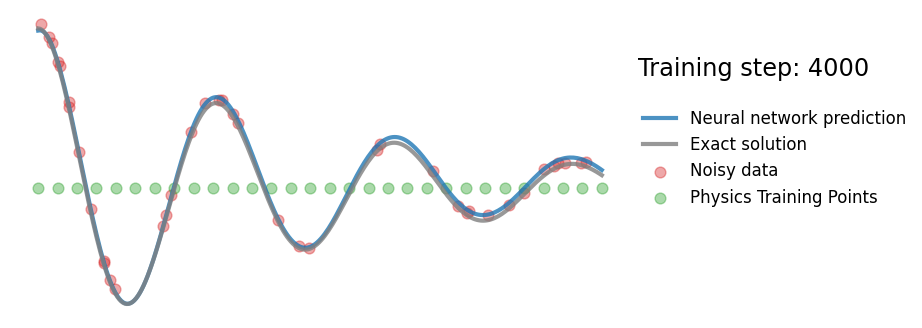

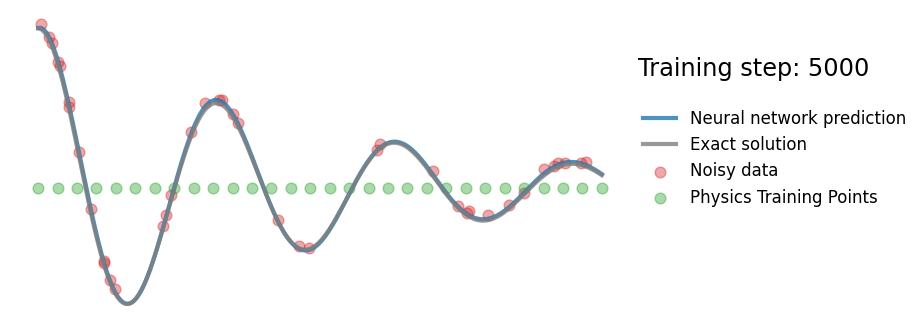

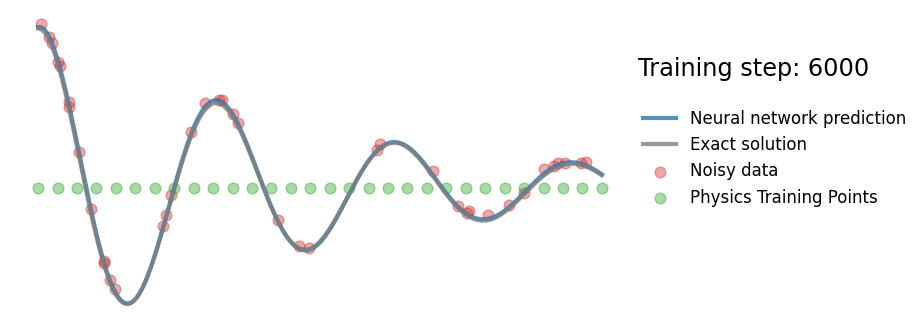

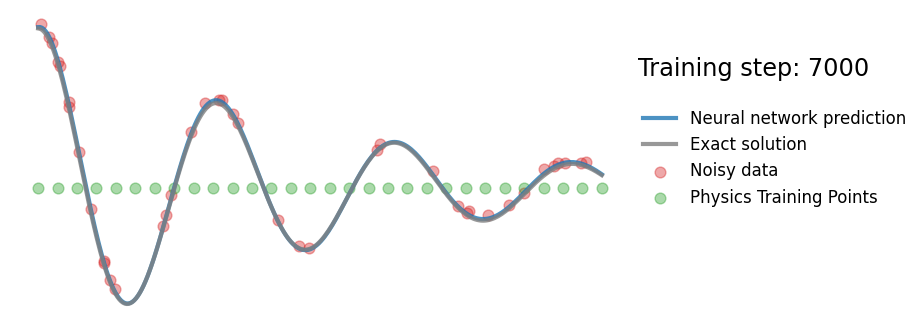

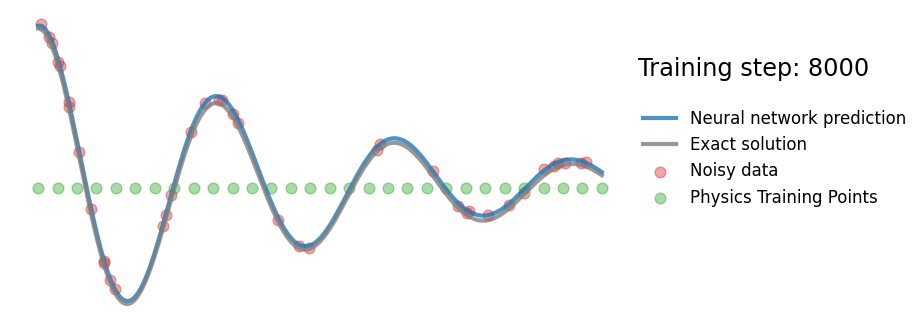

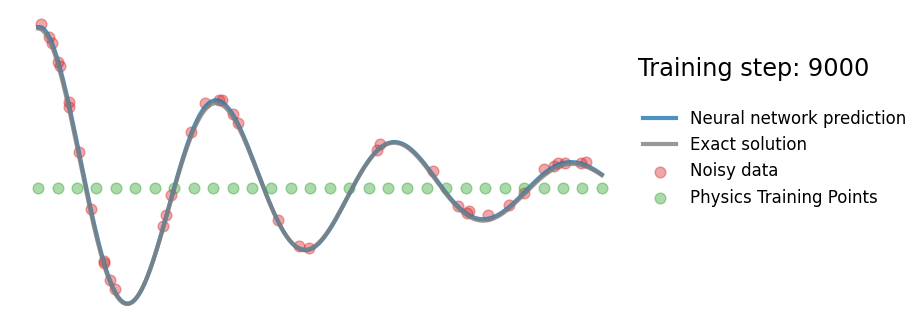

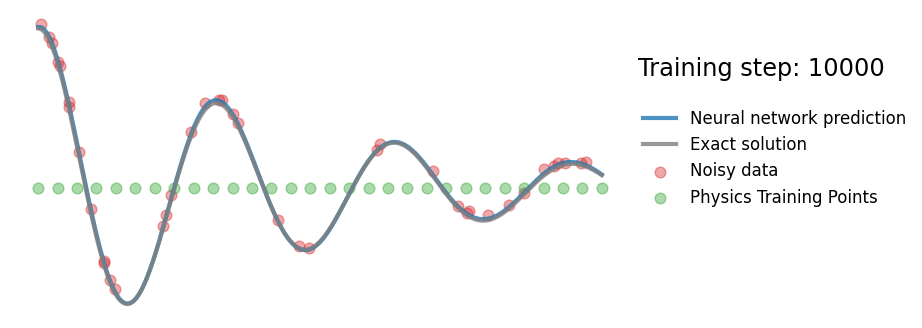

In [28]:
"""Training with Data loss and Physics loss."""
torch.manual_seed(34)
# Physics points
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

_, k = 2 * d, w0 ** 2

# Creating Learnable parameter for mu
mu_l = nn.Parameter(torch.zeros(1, requires_grad = True))

lambda1 = 1e-5
fcn = FCN(1, 1, 34, 3)
optimizer = torch.optim.Adam(list(fcn.parameters()) + [mu_l], lr = 1e-3)       
Loss = []
files = []
Mu = []
for step in tqdm(range(10000)):
    fcn.train()
    # Data loss
    y_p_obs = fcn(t_obs)
    loss_d = torch.mean((y_p_obs - y_obs) ** 2)

    # Physical loss
    y_p_h = fcn(t_physics)
    dudt = torch.autograd.grad(y_p_h, t_physics, torch.ones_like(y_p_h), create_graph = True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph = True)[0]
    loss_p = torch.mean((d2udt2 + mu_l * dudt + k * y_p_h) ** 2)

    # Total loss
    loss = loss_d + lambda1 * loss_p
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    Loss.append(loss.item())
    Mu.append(mu_l.item())
    
    if (step + 1) % 10 == 0:
        fcn.eval()
        y_pred = fcn(t).detach()

        plt.figure(figsize = (8,4))
        plt.plot(t.detach()[:, 0], y_pred[:, 0], color = "tab:blue", linewidth = 3, alpha = 0.8, label = "Neural network prediction")
        plt.plot(t.detach()[:, 0], y.detach()[:, 0], color = "tab:grey", linewidth = 3, alpha = 0.8, label = "Exact solution")
        plt.scatter(t_obs.detach()[:, 0], y_obs.detach()[:, 0], s = 60, color = "tab:red", alpha = 0.4, label = 'Noisy data')
        plt.scatter(t_physics.detach()[:, 0], torch.zeros_like(t_physics)[:, 0], s = 60, color = "tab:green", alpha = 0.4, 
                    label = 'Physics Training Points')
        l = plt.legend(loc = (1.01, 0.34), frameon = False, fontsize = "large")
        plt.setp(l.get_texts(), color = "k")
        plt.text(1.065, 0.7, "Training step: %i"%(step + 1), fontsize = "xx-large", color = "k")
        plt.axis("off")

        file = "Plots_noisy/nn_%.8i.png"%(step + 1)
        plt.savefig(file, bbox_inches = 'tight', pad_inches = 0.1, dpi = 100, facecolor = "white")
        files.append(file)

        if (step + 1) % 1000 == 0:
            plt.show()
        else:
            plt.close('all')


In [29]:
save_gif_PIL('Pinn_noisy.gif', files = files, fps = 40)

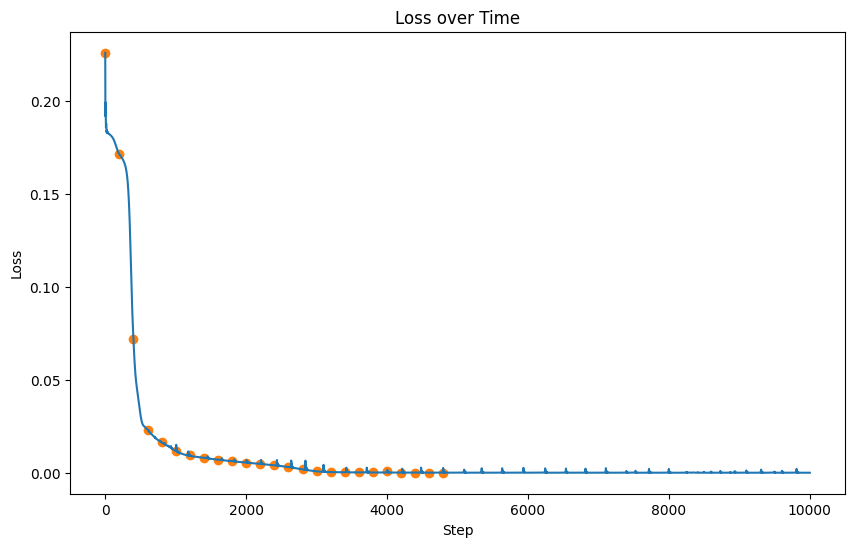

In [30]:
x = range(len(Loss))

plt.figure(figsize = (10, 6))
plt.plot(x, Loss ,'-')
plt.scatter(x[0:5000:200], Loss[0:5000:200], color = "tab:orange")
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()

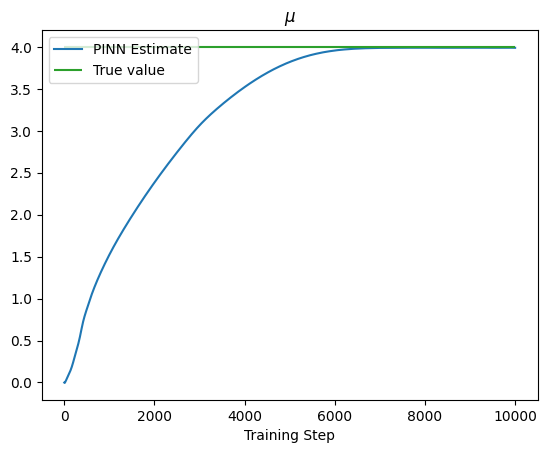

In [31]:
plt.figure()
plt.title('$\mu$')
plt.plot(Mu, label = "PINN Estimate")
plt.hlines(2 * d, 0, len(Mu), label = "True value", color = "tab:green")
plt.legend()
plt.xlabel("Training Step")
plt.show()

It is seen that, $\small \mu$ parameter converges towards true value.

### 6. High Frequency PINN

An intriguing phenomenon observed during training neural networks is the **spectral bias**, which states that neural networks are biased towards learning less complex functions
[Ref](https://ui.adsabs.harvard.edu/abs/2019arXiv191201198C/abstract). Thus, NN struggles to converge towards high frequency waves because of spectral bias, as well as the fact more training points are also required and also need more steps.

In order to make the NN to learn simple function, **Ansatz** approach is used for faster convergence.

    Note: An ansatz is the establishment of the starting equation(s), the theorem(s), or the value(s) describing a mathematical or physical problem or solution. It typically provides an initial estimate or framework to the solution of a mathematical problem. It constitutes nothing more than an assumption, has been established, the equations are solved more precisely for the general function of interest, which then constitutes a confirmation of the assumption. In essence, an ansatz makes assumptions about the form of the solution to a problem so as to make the solution easier to find.

Instead, making the NN to directly approximate the solution of differential equation, i.e. $$ \small u_{NN}(t; \theta) \approx u(t) $$

We make use of NN as a part of mathematical ansatz of the solution, i.e. $$ \normalsize \hat{u}_{NN}(t; \theta, \alpha, \beta) = u_{NN}(t; \theta) \sin(\alpha t + \beta) \approx u(t) \space\space, \small \text{where} \space \alpha \space \text{and} \space \beta \space \text{are learnable parameters.} $$

When comparing this ansatz with original solution, $$ \small u(t) = e^{-\delta t}(2A\cos(\phi + wt)) $$

It is seen that NN needs to learn only the exponential function.

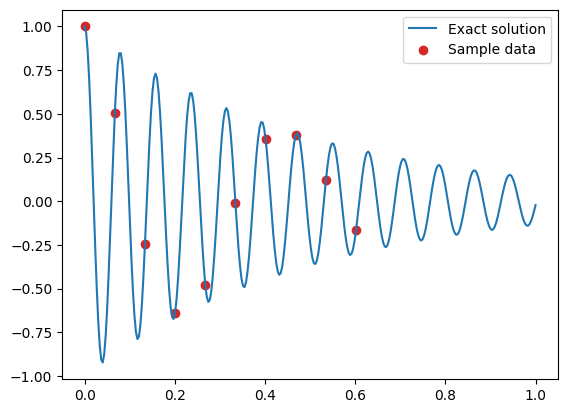

In [32]:
"""Solution for high frequency in time space [0,1]."""
d, w0 = 2, 80
t = torch.linspace(0, 1, 300).view(-1, 1)
y = oscillator(d, w0, t).view(-1, 1)

t_s = t[0:200:20]
y_s = y[0:200:20]

plt.figure()
plt.plot(t, y, label = "Exact solution")
plt.scatter(t_s, y_s, color = "tab:red", label = "Sample data")
plt.legend()
plt.show()

In [33]:
os.makedirs('./Plots_hf')

  0%|          | 0/12000 [00:00<?, ?it/s]

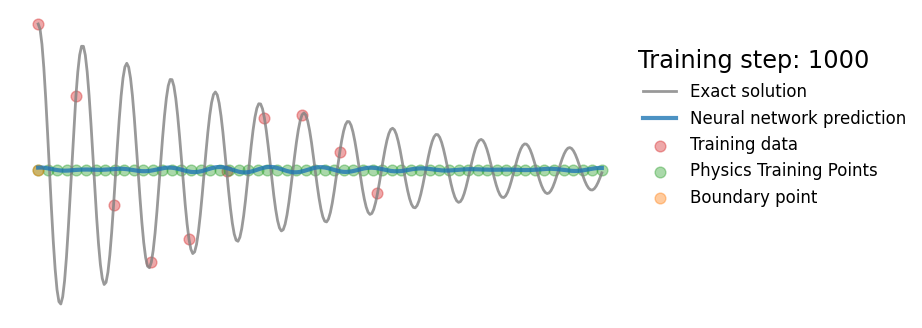

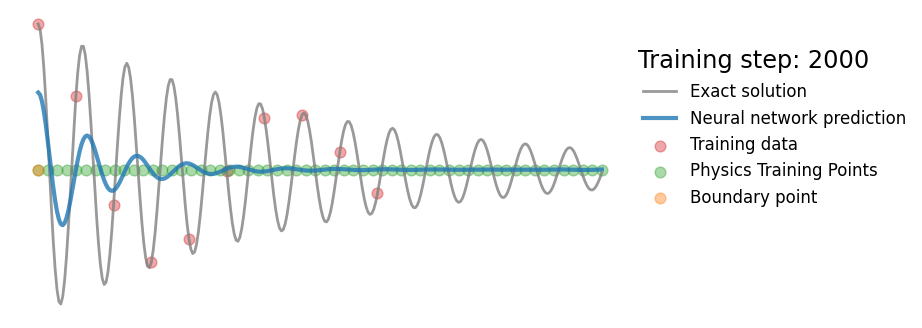

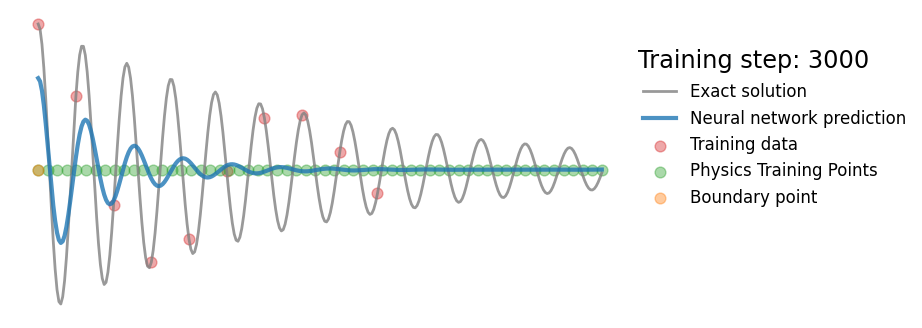

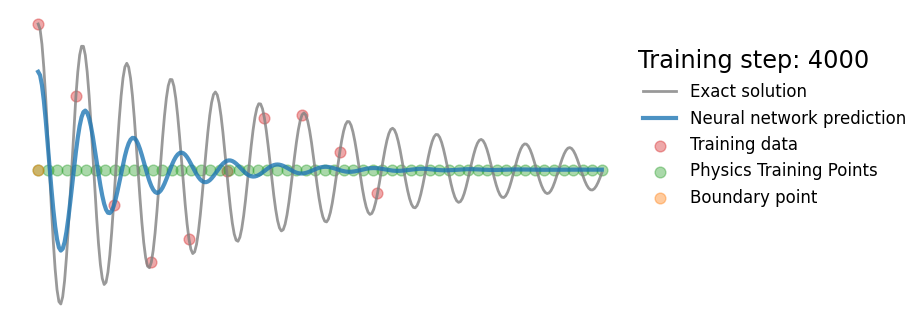

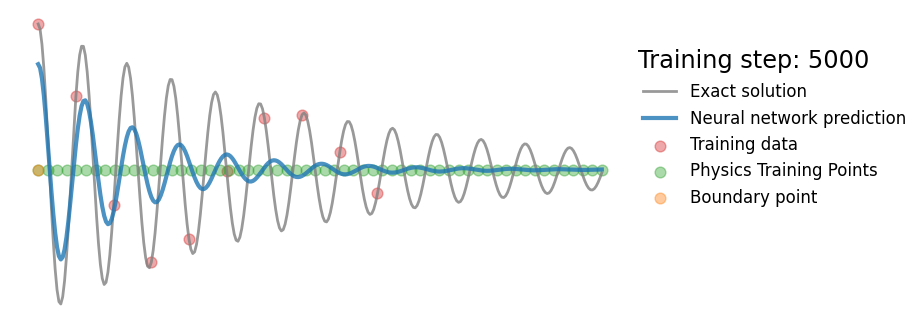

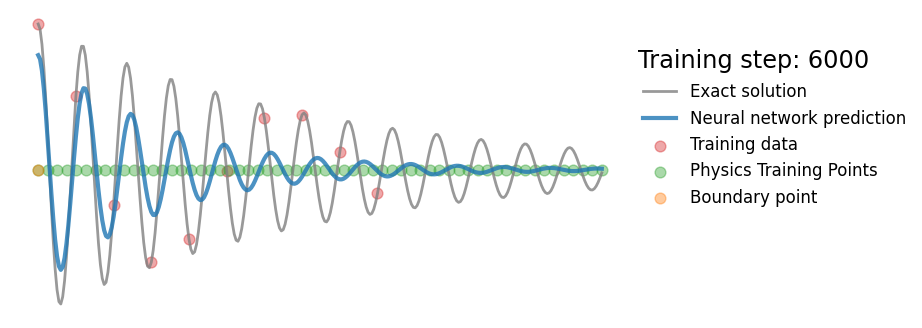

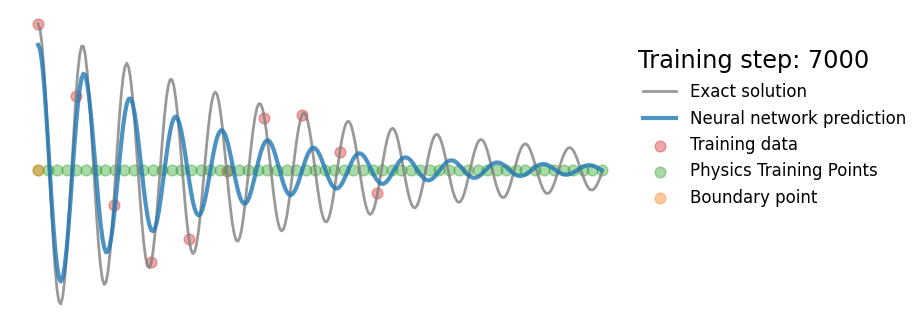

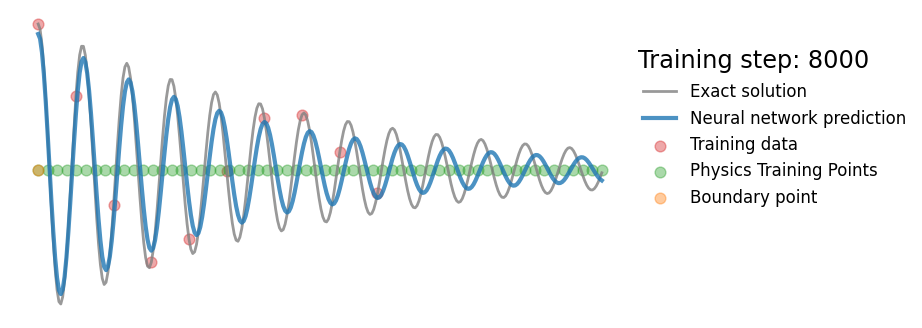

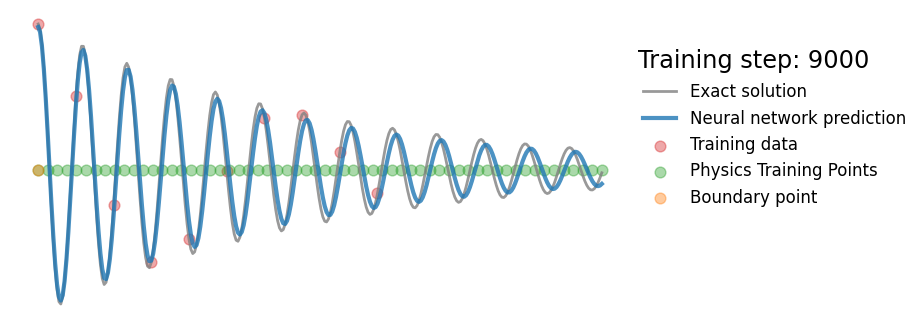

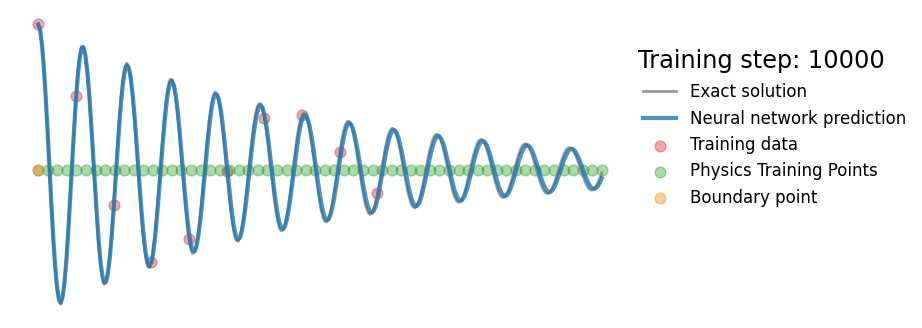

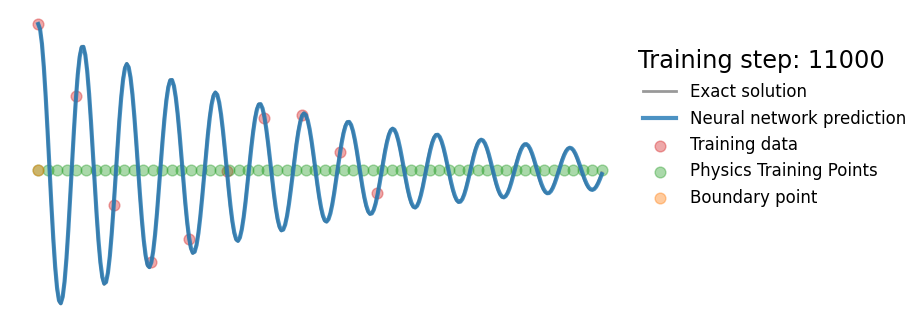

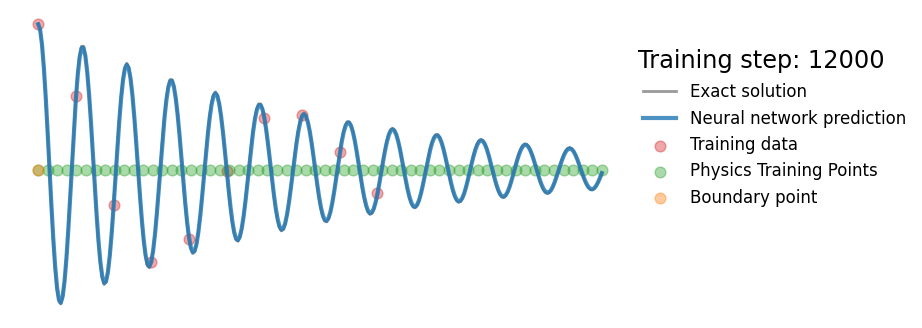

In [50]:
"""Training with Boundary loss and Physics loss."""
torch.manual_seed(34)

# Boundary point
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
# Physics points
t_physics = torch.linspace(0, 1, 60).view(-1, 1).requires_grad_(True)

# Creating Learnable parameters for ansatz equation
a = nn.Parameter(70 * torch.ones(1, requires_grad = True))
b = nn.Parameter(torch.ones(1, requires_grad = True))

mu, k = 2 * d, w0 ** 2

lambda1, lambda2 = 1e-1, 1e-5
fcn = FCN(1, 1, 34, 3)
optimizer = torch.optim.Adam(list(fcn.parameters()) + [a, b], lr = 1e-3)       
Loss = []
files = []
for step in tqdm(range(12000)):
    fcn.train()
    optimizer.zero_grad()
    # Boundary loss
    y_p_b = fcn(t_boundary) * torch.sin(a * t_boundary + b)
    loss_b1 = (torch.squeeze(y_p_b) - 1) ** 2

    dudt_pinn = torch.autograd.grad(y_p_b, t_boundary, torch.ones_like(y_p_b), create_graph = True)[0]
    loss_b2 = (torch.squeeze(dudt_pinn) - 0) ** 2

    # Physical loss
    y_p_h = fcn(t_physics) * torch.sin(a * t_physics + b)
    dudt = torch.autograd.grad(y_p_h, t_physics, torch.ones_like(y_p_h), create_graph = True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph = True)[0]
    loss_p = torch.mean((d2udt2 + mu * dudt + k * y_p_h) ** 2)

    # Total loss
    loss = loss_b1 + lambda1 * loss_b2 + lambda2 * loss_p
    loss.backward()
    optimizer.step()
    Loss.append(loss.item())
    
    if (step + 1) % 10 == 0:
        fcn.eval()
        y_pred = (fcn(t) * torch.sin(a * t + b)).detach()

        plot_result(t.detach(), y.detach(), t_s, y_s, y_pred, step, xp = t_physics.detach(), xb = t_boundary.detach())

        file = "Plots_hf/nn_%.8i.png"%(step + 1)
        plt.savefig(file, bbox_inches = 'tight', pad_inches = 0.1, dpi = 100, facecolor = "white")
        files.append(file)

        if (step + 1) % 1000 == 0:
            plt.show()
        else:
            plt.close('all')


In [51]:
save_gif_PIL('Pinn_hf.gif', files = files, fps = 30)

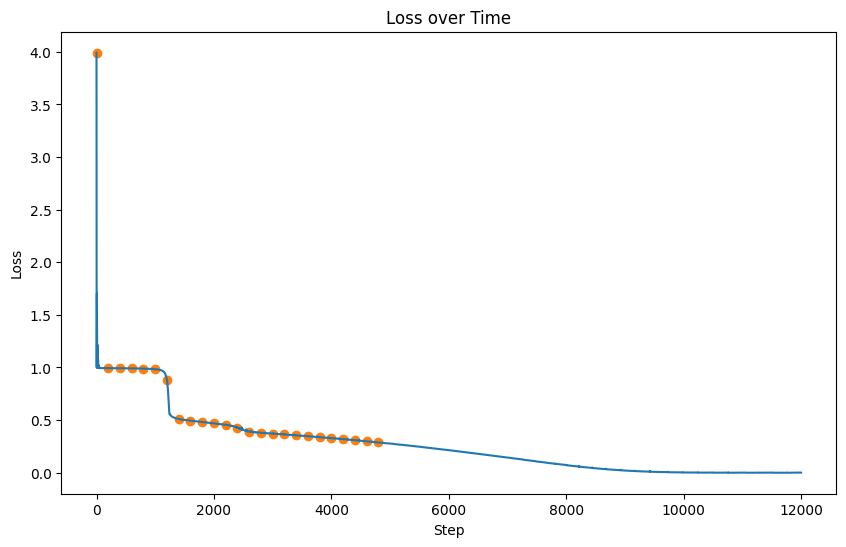

In [52]:
x = range(len(Loss))

plt.figure(figsize = (10, 6))
plt.plot(x, Loss ,'-')
plt.scatter(x[0:5000:200], Loss[0:5000:200], color = "tab:orange")
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()

### 7.References:
1. [Blog](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/)
2. [YouTube](https://youtu.be/G_hIppUWcsc?si=D8g0EmfbuquB66-_)
3. [Paper](https://arxiv.org/pdf/2401.02810.pdf).